In [ ]:
import torch  # Main PyTorch library
from torch import nn  # Neural network components for building models

import torchvision  # Library with tools for computer vision
from torchvision.transforms import ToTensor, transforms  # Tools to process images
from torch.utils.data import DataLoader, Subset, Dataset, random_split  # Tools to handle data
import torch.nn.functional as F


from torchsummary import summary  # Prints a nice summary of your model
from tqdm import tqdm  # Adds progress bars to your loops

import matplotlib as plt  # Library for creating charts and visuals
import matplotlib.pyplot as plt  # The part of matplotlib for actually drawing plots
import numpy as np  # For working with arrays and math operations
import pandas as pd

import nibabel as nib
import os



print(torch.__version__)  # Shows which version of PyTorch you're using

2.7.1+cpu


In [2]:
import pandas as pd 
file_path = '/Users/baumn/Downloads/commercial_mri_nacc69.csv'  # Replace with the actual file path
#columns_to_read = ['AMYLPET', 'AMYLCSF', 'TAUPETAD', 'CSFTAU', 'NACCHTNC', 'NACCHTNC', 'NACCACEI', 'NACCAAAS', 'NACCBETA', 'NACCCCBS', 'NACCDIUR', 'NACCVASD', 'NACCANGI', 'NACCLIPL', 'NACCNSD', 'NACCAC', 'NACCADEP', 'NACCAPSY', 'NACCAANX', 'NACCADMD', 'NACCPDMD', 'NACCEMD', 'NACCEPMD', 'NACCDBMD']
columns_to_read = [ "NACCID", "GRAYVOL",
    "LCAC", "RCAC", "LCMF", "RCMF", "LCUN", "RCUN", "LENT", "RENT",
    "LFUS", "RFUS", "LINFPAR", "RINFPAR", "LINFTEMP", "RINFTEMP",
    "LINSULA", "RINSULA", "LISTHC", "RISTHC", "LLATOCC", "RLATOCC",
    "LLATORBF", "RLATORBF", "LLING", "RLING", "LMEDORBF", "RMEDORBF",
    "LMIDTEMP", "RMIDTEMP", "LPARCEN", "RPARCEN", "LPARHIP", "RPARHIP",
    "LPARSOP", "RPARSOP", "LPARORB", "RPARORB", "LPARTRI", "RPARTRI",
    "LPERCAL", "RPERCAL", "LPOSCEN", "RPOSCEN", "LPOSCIN", "RPOSCIN",
    "LPRECEN", "RPRECEN", "LPRECUN", "RPRECUN", "LROSANC", "RROSANC",
    "LROSMF", "RROSMF", "LSUPFR", "RSUPFR", "LSUPPAR", "RSUPPAR",
    "LSUPTEM", "RSUPTEM", "LSUPMAR", "RSUPMAR", "LTRTEM", "RTRTEM"
]



df = pd.read_csv(file_path, usecols=columns_to_read)

df = df[df["LCAC"] != 88.8888]

print(df.head())
df.shape


       NACCID  GRAYVOL  LCAC  LCMF  LCUN  LENT   LFUS  LINFPAR  LINFTEMP  \
0  NACC914950   622.96  3.03  6.81  5.97  3.93  10.89    12.63      7.71   
1  NACC388999   564.43  3.44  5.60  4.05  3.34   8.78     8.65     10.64   
3  NACC550785   696.87  3.32  6.05  3.82  4.92  10.49    15.71     11.92   
4  NACC321645   613.94  4.63  6.04  3.96  4.43  10.08     8.48      9.41   
5  NACC129206   664.14  4.27  5.29  5.73  3.67  10.64    11.59      9.19   

   LINSULA  ...  RPOSCIN  RPRECEN  RPRECUN  RROSANC  RROSMF  RSUPFR  RSUPPAR  \
0     6.19  ...     4.26    12.20     8.56     2.37   10.56   28.26    10.53   
1     6.07  ...     3.91    11.31     8.47     2.55   12.01   24.92    10.17   
3     7.86  ...     5.14    15.26     9.38     2.95   11.63   30.55    13.20   
4     5.81  ...     4.01    13.02     8.99     2.10   13.27   27.86    12.02   
5     5.13  ...     3.43    13.20    11.14     2.69   12.73   24.44    13.44   

   RSUPTEM  RSUPMAR  RTRTEM  
0    15.71     7.24    0.72  
1 

(4434, 64)

In [3]:
import os

def list_immediate_folders(path):
    folders = []
    for item in os.listdir(path):
        item_path = os.path.join(path, item)
        if os.path.isdir(item_path):
            folders.append(item)
    return folders

# Example usage
parent_folder = "/Users/baumn/Downloads/nifti2" # Replace with the actual path
subfolders = list_immediate_folders(parent_folder)
print(subfolders)



['1018_NACC001341_20170307ni', '1018_NACC002424_20170509ni', '1018_NACC004873_20190826ni', '1018_NACC006454_20170727ni', '1018_NACC007445_20190430ni', '1018_NACC007737_20191014ni', '1018_NACC008987_20190211ni', '1018_NACC013585_20190311ni', '1018_NACC015412_20180315ni', '1018_NACC015790_20170223ni', '1018_NACC016272_20190301ni', '1018_NACC016727_20170814ni', '1018_NACC251761_20200116ni', '1018_NACC494169_20180706ni', '1018_NACC607747_20190830ni', '1018_NACC730677_20180514ni', '1018_NACC731128_20160902ni', '1018_NACC887073_20190215ni', '943_NACC154191_20200228ni', 'NACC000225_128401136192134176253428328711252519741662ni', 'NACC000225_128401136192134176253428332741326220813706ni', 'NACC000511_128401136196374286166399658190153668119088781840619368ni', 'NACC000531_128401136196408180296700658409757386939198398856515105ni', 'NACC000531_12840113619645367048588911883923602953867708299785103ni', 'NACC001589_13122110752436604430000019072520373772500000079ni', 'NACC001959_128401136192134176253428

In [4]:
list_x = []
for i in subfolders:
    for x in df["NACCID"]:
        if x in i:
            list_x.append(x)
print(set(list_x))
print(len(set(list_x)))

list2 = []
for i in subfolders:
    for x in df["NACCID"]:
        if x in i:
            list2.append(i)
print(set(list2))
print(len(set(list2)))

x=0
for i in set(list_x):
    if i == "NACC234794":
        x+=1

print(x)


{'NACC003196', 'NACC365499', 'NACC269863', 'NACC383575', 'NACC011853', 'NACC376580', 'NACC132998', 'NACC191311', 'NACC093849', 'NACC025918', 'NACC381287', 'NACC071703', 'NACC037828', 'NACC181584', 'NACC369086', 'NACC402140', 'NACC146825', 'NACC271325', 'NACC047337', 'NACC213060', 'NACC332393', 'NACC356486', 'NACC022031', 'NACC098465', 'NACC318086', 'NACC180492', 'NACC065134', 'NACC201406', 'NACC284078', 'NACC237530', 'NACC284263', 'NACC332484', 'NACC251885', 'NACC402820', 'NACC160145', 'NACC121305', 'NACC044628', 'NACC323776', 'NACC331862', 'NACC236983', 'NACC106245', 'NACC020803', 'NACC247521', 'NACC205350', 'NACC318168', 'NACC376100', 'NACC354728', 'NACC020061', 'NACC019731', 'NACC173968', 'NACC025174', 'NACC077159', 'NACC336297', 'NACC040578', 'NACC093145', 'NACC145549', 'NACC146151', 'NACC042407', 'NACC221012', 'NACC353393', 'NACC190351', 'NACC332258', 'NACC195664', 'NACC216641', 'NACC353577', 'NACC149494', 'NACC231983', 'NACC096197', 'NACC036265', 'NACC214544', 'NACC358181', 'NACC

In [5]:
df2 = df[df["NACCID"].isin(set(list_x))]    
df2
df2['VALUE'] = np.where(df2['GRAYVOL'] > 600, 1, 0)

print(df2.head())
df2.shape



         NACCID  GRAYVOL    LCAC    LCMF    LCUN    LENT     LFUS  LINFPAR  \
299  NACC105473  656.384  5.0801  3.8193  4.3057  4.6497  10.0018   9.0978   
306  NACC210038  482.802  3.3364  4.3106  3.4873  3.5291   6.0333  11.0670   
330  NACC402274  593.583  3.4132  2.9234  4.2806  4.4038   7.7141   7.2229   
331  NACC402274  589.486  4.4223  2.9690  6.5222  4.4139   9.7158   9.4679   
341  NACC354797  552.604  4.2071  3.5764  5.5139  3.8812  10.0786  11.8072   

     LINFTEMP  LINSULA  ...  RPRECEN  RPRECUN  RROSANC   RROSMF   RSUPFR  \
299   10.7314   6.0257  ...  10.5698   8.8914   3.4865  12.6931  28.1686   
306    7.0568   5.3610  ...   9.0694   7.6873   2.3966  11.0491  17.7548   
330    8.8229   5.0676  ...   9.7752   5.5671   2.4655  11.5390  19.9178   
331    8.5767   6.0961  ...  12.0646   6.6256   2.7253  11.8326  23.8718   
341    7.4387   5.1616  ...   9.5175   8.9543   2.2929   9.5649  21.5862   

     RSUPPAR  RSUPTEM  RSUPMAR  RTRTEM  VALUE  
299  10.6450  13.8979   7.

C:\Users\baumn\AppData\Local\Temp\ipykernel_21680\3397482380.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['VALUE'] = np.where(df2['GRAYVOL'] > 600, 1, 0)


(879, 65)

In [296]:
class ConvNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv_layers = nn.Sequential(
        #we have 2 layers. the first one detects low level info like edges, textures, and basic patterns.
        #second detects higher ones like shapes structre ofject parts.

        nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),  # Conv layer (3 input channels -> 16 filters)
        nn.BatchNorm2d(16),  # This stabilizes training by reducing internal covariate shift,
        # Ignore BatchNorm for now, focus on understanding (Conv, Relu, Pooling)
        nn.ReLU(),  # Activation function for non-linearity
        nn.MaxPool2d(kernel_size=2, stride=2),  # Downsampling (reduces feature map size)

        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),  # Conv layer (16 filters -> 32 filters)
        nn.BatchNorm2d(32),  # Batch normalization for stable training
        nn.ReLU(),  # Activation function
        nn.MaxPool2d(kernel_size=2, stride=2),  # Downsampling

        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),  # Conv layer (16 filters -> 32 filters)
        nn.BatchNorm2d(64),  # Batch normalization for stable training
        nn.ReLU(),  # Activation function
        nn.MaxPool2d(kernel_size=2, stride=2),  # Downsampling
        #instead of learning all features in one big convolutional later, we gradually increase number of filters

        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),  # Conv layer (16 filters -> 32 filters)
        nn.BatchNorm2d(128),  # Batch normalization for stable training
        nn.ReLU(),  # Activation function
        nn.MaxPool2d(kernel_size=2, stride=2),  # Downsampling
        #instead of learning all features in one big convolutional later, we gradually increase number of filters

        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),  # Conv layer (16 filters -> 32 filters)
        nn.BatchNorm2d(256),  # Batch normalization for stable training
        nn.ReLU(),  # Activation function
        nn.MaxPool2d(kernel_size=2, stride=2)  # Downsampling
        #instead of learning all features in one big convolutional later, we gradually increase number of filters
    )
 

    self.flatten = nn.Flatten()  # Flattens feature maps into a 1D vector

    self.fully_connected = nn.Sequential(
        nn.Linear(in_features=256*8*8, out_features=128),  # Fully connected layer (flattened input -> 128 neurons)
        nn.ReLU(),  # Activation function
        nn.Dropout(0.3),
        nn.Linear(in_features=128, out_features=2),  # Output layer (10 classes for classification)
    ) #Make it simpler (binary)




  def forward(self, x):
    x = self.conv_layers(x)  # Pass input through convolutional layers
    #print(f'Shape coming out of convnet will be: {x.shape}')  # Debugging output
    x = self.flatten(x)  # Flatten feature maps for fully connected layers
    x = self.fully_connected(x)  # Pass through fully connected layers
    return x

model = ConvNet()  # Create an instance of the model

In [239]:
columns_to_read2 = [ 
    "VALUE"
]

In [326]:
class MyData(Dataset):
    """
    Dataset for loading neuroimaging data (.nii or .nii.gz) with labels from a preloaded DataFrame.
    
    Args:
        root_dir (str): Directory containing NIfTI files.
        labels_df (DataFrame): Pandas DataFrame with at least 'subject_id' and 'label' columns.
    """
    def __init__(self, root_dir, labels_df, label_column):
        self.root_dir = root_dir
        self.labels_df = labels_df
        self.label_column = label_column
        self.samples = self.make_dataset()
        
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        nifti_data = nib.load(img_path)
        data = nifti_data.get_fdata()

        if data.ndim == 4:
            data = data[:, :, :, 0]

        if data.ndim != 3:
            raise ValueError(f"Expected 3D volume, got shape {data.shape} at {img_path}")

        mid_slice = data.shape[2] // 2
        slice_2d = data[:, :, mid_slice]
        if slice_2d.ndim != 2:
            raise ValueError(f"Expected 2D slice, got shape {slice_2d.shape} at {img_path}")


        slice_2d = (slice_2d - slice_2d.min()) / (slice_2d.max() - slice_2d.min() + 1e-5)

        #slice_2d = np.array(slice_2d, dtype=np.float32)



        image_tensor = torch.tensor(slice_2d, dtype=torch.float32)
        image_tensor=image_tensor.unsqueeze(0).unsqueeze(0)  # shape: [1, D, H, W]

        if image_tensor.ndim != 4:
            raise ValueError(f"Before interpolation, shape is {image_tensor.shape}")
    
        image_tensor = F.interpolate(image_tensor, size=(256,256), mode='bilinear', align_corners=False)
        image_tensor = image_tensor.squeeze(0)

        label_tensor = torch.tensor(label, dtype=torch.long).squeeze()
        
        return image_tensor, label_tensor

    def make_dataset(self):
        samples = []
        for dirpath, _, filenames in os.walk(self.root_dir):
            for file in filenames:
                if file.endswith(".nii.gz") or file.endswith(".nii"):
                    path = os.path.join(dirpath, file)
                    subject_id = os.path.basename(os.path.dirname(path))[:10]

                    label_row = self.labels_df[self.labels_df['NACCID'] == subject_id]
                    if not label_row.empty:
                        label = label_row.iloc[0][self.label_column]
                        # Ensure label is a 1D array
                        if isinstance(label, (np.ndarray, list, tuple)):
                            label = np.array(label, dtype=np.float32)
                        else:
                            label = np.array([label], dtype=np.float32)
                        samples.append((path, label))
                    else:
                        print(f"Warning: No label found for subject ID {subject_id}")
        return samples


    def extract_id_from_filename(self, fname):
        """
        Extract the subject ID from the filename.
        Modify this depending on your filename structure.
        Example: 'sub-12345678_something.nii.gz' -> 'sub-12345678'
        """
        return fname.split('_')[0]  # adjust based on your actual filename pattern

In [ ]:
dataset = MyData(root_dir='/Users/baumn/Downloads/nifti3', labels_df=df2, label_column = columns_to_read2)
print(f"Number of samples: {len(dataset)}")
#print(dataset.data.shape)
#print(dataset[1][1])
#image, label = dataset[0]
#print(image)
#print(label)
#print("Image shape:", image.shape)        # e.g. torch.Size([1, D, H, W])
#print("Label:", label)
#print("Label shape:", label.shape)
#print("Image dtype:", image.dtype)
#print("Label dtype:", label.dtype)


#for i in range(len(dataset)):
    #image, label = dataset[i]
    #print(f"Sample {i}: label={label.tolist()}, shape={label.shape}")

#print(dataset.label)
from torch.utils.data import DataLoader

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


#print(dataloader.shape)

for x, y in train_loader:
    print(f"Batch image shape: {x.shape}")  # [batch_size, 1, D, H, W]
    print(f"Batch labels: {y}")
    break


Number of samples: 2376
Batch image shape: torch.Size([32, 1, 256, 256])
Batch labels: tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 1, 0, 0, 1, 1, 0])


In [328]:
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvNet().to(device)

criterion = nn.CrossEntropyLoss()  # For classification
optimizer = optim.Adam(model.parameters(), lr=0.0001)


In [329]:
def train_loop(train_dataloader, model, loss_fn, optimizer, epochs):
  model.train() # Put the model in training mode
  train_loss = []
  for epoch in range(epochs):
    train_loss_epoch = 0
    for image, label in tqdm(train_dataloader, desc="Training Model"):
      image, label = image.to(device), label.to(device).long()
      # print(f'Shape of the images: {image.shape}')
      # print(f'Shape of the labels: {label.shape}')
      # print(label)
      # input()

      optimizer.zero_grad()

      pred = model(image)
      #print(pred)
      #print(pred.shape)
      #print(label.shape)
      #input()
      loss = loss_fn(pred, label) # Prediction has to go first (Calculate loss between the prediction and the true value)
      loss.backward()
      train_loss_epoch += loss.item()

      optimizer.step()

    avg_loss = train_loss_epoch / len(train_dataloader)
    train_loss.append(avg_loss)

    print(f'Epoch: {epoch+1} | Loss: {avg_loss:.4f}')

  return train_loss

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
model.to(device)


cpu


ConvNet(
  (conv_layers): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [330]:
num_epochs = 25
losses = train_loop(train_loader, model, criterion, optimizer, epochs=num_epochs) # Lets take a few minute break while it trains and we will come back

Training Model: 100%|██████████| 60/60 [02:49<00:00,  2.82s/it]


Epoch: 1 | Loss: 0.5612


Training Model: 100%|██████████| 60/60 [02:50<00:00,  2.84s/it]


Epoch: 2 | Loss: 0.4928


Training Model: 100%|██████████| 60/60 [02:48<00:00,  2.81s/it]


Epoch: 3 | Loss: 0.4654


Training Model: 100%|██████████| 60/60 [02:27<00:00,  2.46s/it]


Epoch: 4 | Loss: 0.4301


Training Model: 100%|██████████| 60/60 [02:17<00:00,  2.29s/it]


Epoch: 5 | Loss: 0.3984


Training Model: 100%|██████████| 60/60 [02:18<00:00,  2.30s/it]


Epoch: 6 | Loss: 0.3396


Training Model: 100%|██████████| 60/60 [02:17<00:00,  2.30s/it]


Epoch: 7 | Loss: 0.3229


Training Model: 100%|██████████| 60/60 [02:19<00:00,  2.33s/it]


Epoch: 8 | Loss: 0.2404


Training Model: 100%|██████████| 60/60 [02:52<00:00,  2.87s/it]


Epoch: 9 | Loss: 0.1876


Training Model: 100%|██████████| 60/60 [02:52<00:00,  2.87s/it]


Epoch: 10 | Loss: 0.1290


Training Model: 100%|██████████| 60/60 [02:54<00:00,  2.90s/it]


Epoch: 11 | Loss: 0.0799


Training Model: 100%|██████████| 60/60 [02:42<00:00,  2.70s/it]


Epoch: 12 | Loss: 0.0561


Training Model: 100%|██████████| 60/60 [02:53<00:00,  2.88s/it]


Epoch: 13 | Loss: 0.0402


Training Model: 100%|██████████| 60/60 [02:38<00:00,  2.64s/it]


Epoch: 14 | Loss: 0.0286


Training Model: 100%|██████████| 60/60 [02:35<00:00,  2.59s/it]


Epoch: 15 | Loss: 0.0226


Training Model: 100%|██████████| 60/60 [02:35<00:00,  2.59s/it]


Epoch: 16 | Loss: 0.0183


Training Model: 100%|██████████| 60/60 [02:45<00:00,  2.76s/it]


Epoch: 17 | Loss: 0.0139


Training Model: 100%|██████████| 60/60 [02:53<00:00,  2.89s/it]


Epoch: 18 | Loss: 0.0103


Training Model: 100%|██████████| 60/60 [02:52<00:00,  2.87s/it]


Epoch: 19 | Loss: 0.0088


Training Model: 100%|██████████| 60/60 [02:52<00:00,  2.88s/it]

Epoch: 20 | Loss: 0.0088


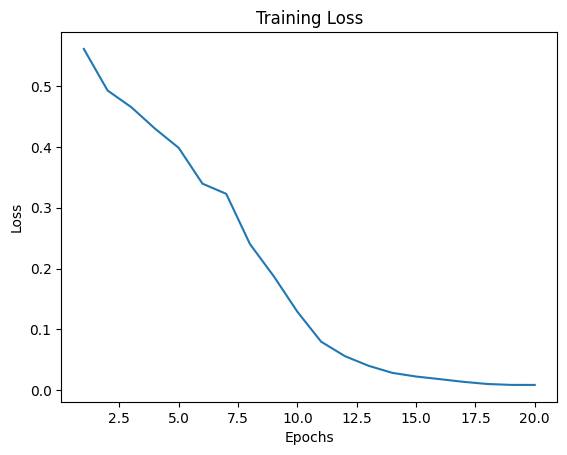

In [331]:
epoch_list = list(range(1, num_epochs+1))
plt.plot(epoch_list, losses)
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [332]:
def accuracy(correct, total):
  return correct/total * 100

def test_loop(test_dataloader, model):
  model.eval() # Put the model in evaluation mode
  correct = 0
  total = 0

  with torch.no_grad():
    for image, label in tqdm(test_dataloader, desc="Testing Model"):
      image, label = image.to(device), label.to(device)

      pred = model(image)

      correct += (pred.argmax(1) == label).type(torch.float).sum().item()
      total += len(label)

    print(f'Accuracy: {accuracy(correct, total)}')

In [333]:
test_loop(test_loader, model)



Testing Model: 100%|██████████| 15/15 [00:30<00:00,  2.05s/it]

Accuracy: 81.5126050420168


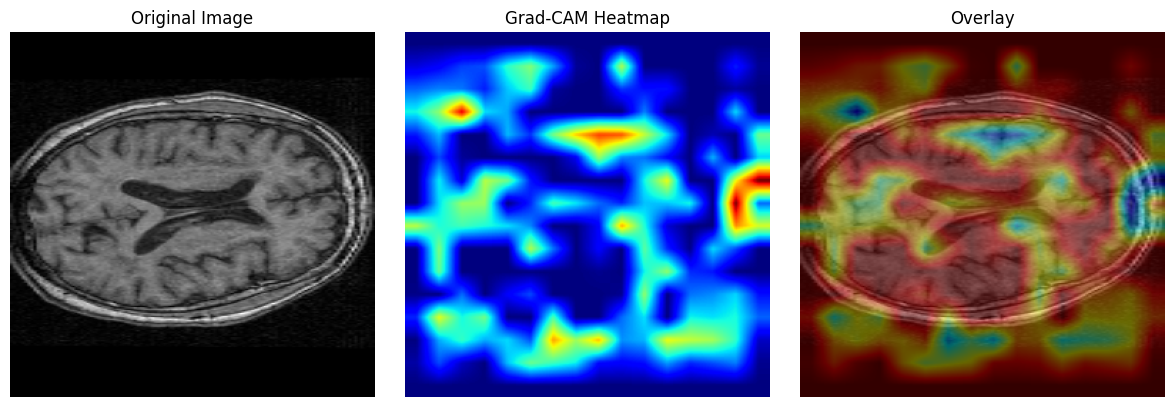

In [316]:
import cv2

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer

        self.activations = None
        self.gradients = None

        # Register hook to get gradients during backprop
        self.hook_handles = []
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        self.hook_handles.append(self.target_layer.register_forward_hook(forward_hook))
        self.hook_handles.append(self.target_layer.register_full_backward_hook(backward_hook))

    def remove_hooks(self):
        for handle in self.hook_handles:
            handle.remove()

    def generate(self, input_tensor, class_idx=None):
        self.model.eval()
        output = self.model(input_tensor)

        if class_idx is None:
            class_idx = torch.argmax(output, dim=1).item()

        self.model.zero_grad()
        class_score = output[0, class_idx]
        class_score.backward()

        # Grad-CAM calculation
        pooled_grads = torch.mean(self.gradients, dim=[0, 2, 3])
        for i in range(self.activations.shape[1]):
            self.activations[0, i, :, :] *= pooled_grads[i]

        heatmap = torch.mean(self.activations, dim=1).squeeze()
        heatmap = np.maximum(heatmap.cpu().numpy(), 0)
        heatmap /= (heatmap.max() + 1e-8)
        return heatmap

def show_gradcam_on_image(input_tensor, heatmap):
    image_np = input_tensor.squeeze().cpu().numpy()
    heatmap_resized = cv2.resize(heatmap, (image_np.shape[1], image_np.shape[0]))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)

    # Convert grayscale to 3-channel for overlay
    image_3ch = np.stack([image_np * 255] * 3, axis=-1).astype(np.uint8)

    overlay = cv2.addWeighted(heatmap_colored, 0.4, image_3ch, 0.6, 0)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(image_np, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Grad-CAM Heatmap")
    plt.imshow(heatmap_resized, cmap='jet')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Overlay")
    plt.imshow(overlay)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Get a sample image and label from your dataset
image, label = dataset[0]
input_tensor = image.unsqueeze(0).to(device)  # Add batch dimension

# Identify the last conv layer from model

target_layer = model.conv_layers[16]  # Last Conv2d

# Apply Grad-CAM
gradcam = GradCAM(model, target_layer)
heatmap = gradcam.generate(input_tensor)
gradcam.remove_hooks()

# Visualize
show_gradcam_on_image(image, heatmap)

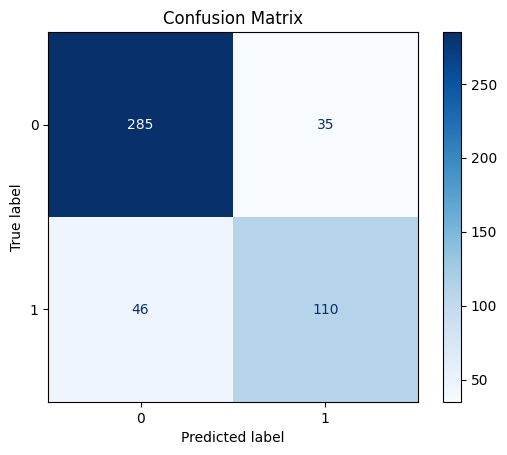

In [312]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# After testing/predicting
y_true = []
y_pred = []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images.to(device))
        preds = torch.argmax(outputs, dim=1).cpu()
        y_pred.extend(preds.numpy())
        y_true.extend(labels.numpy())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

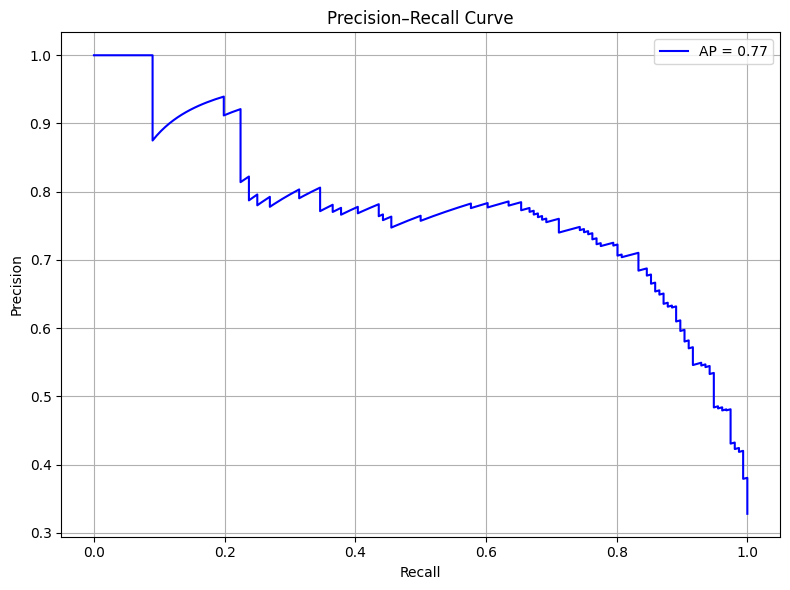

In [317]:
from sklearn.metrics import precision_recall_curve, average_precision_score


def plot_precision_recall(model, dataloader, device):
    model.eval()
    y_true = []
    y_prob = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)  # raw logits
            probs = torch.softmax(outputs, dim=1)  # convert to probabilities

            y_true.extend(labels.cpu().numpy())
            y_prob.extend(probs[:, 1].cpu().numpy())  # take prob for class 1

    y_true = np.array(y_true)
    y_prob = np.array(y_prob)

    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    ap = average_precision_score(y_true, y_prob)

    # Plot
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'AP = {ap:.2f}', color='blue')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision–Recall Curve')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_precision_recall(model, test_loader, device)


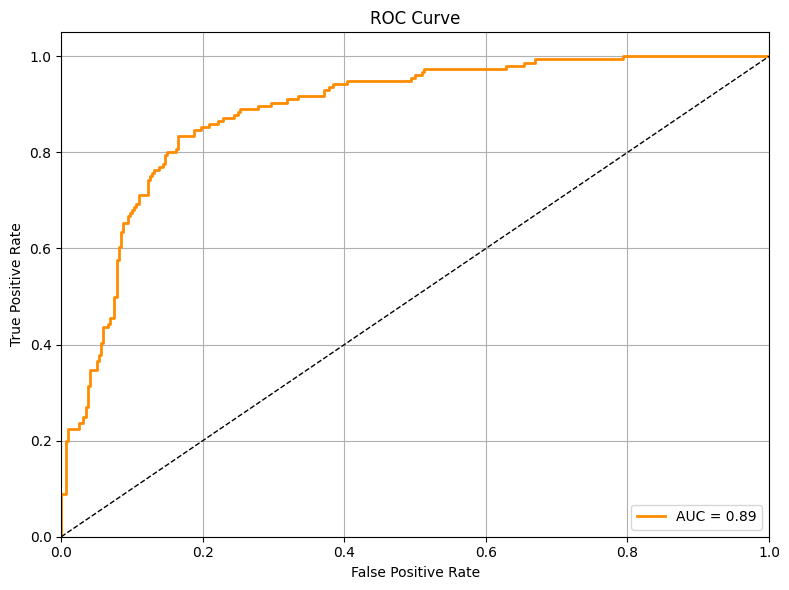

In [319]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(model, dataloader, device):
    model.eval()
    y_true = []
    y_prob = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)  # raw logits
            probs = torch.softmax(outputs, dim=1)  # convert to probabilities

            y_true.extend(labels.cpu().numpy())
            y_prob.extend(probs[:, 1].cpu().numpy())  # probability of class 1

    y_true = np.array(y_true)
    y_prob = np.array(y_prob)

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)

    # Plot
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--', lw=1)  # random baseline
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.grid(True)
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

plot_roc_curve(model, test_loader, device)


0.8298319327731093


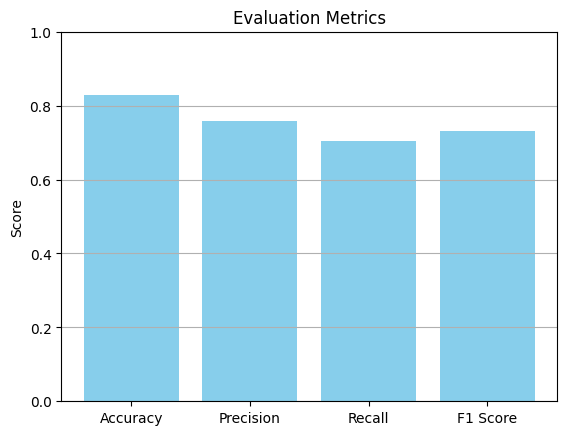

In [320]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

metrics = {
    "Accuracy": accuracy_score(y_true, y_pred),
    "Precision": precision_score(y_true, y_pred),
    "Recall": recall_score(y_true, y_pred),
    "F1 Score": f1_score(y_true, y_pred),
}

print(accuracy_score(y_true, y_pred))

plt.bar(metrics.keys(), metrics.values(), color='skyblue')
plt.ylim(0, 1)
plt.title("Evaluation Metrics")
plt.ylabel("Score")
plt.grid(axis='y')
plt.show()